My Transformer

21/05/18

한규인 

## Library Import

In [ ]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

## Function Define

In [ ]:
# query, key, value를 이용해서 self_attention을 구하고, 최종 Output을 계산합니다.

def scaled_dot_product_attention(query, key, value, mask) :

    # Query : (batch_size, n_head, n_seq, query_dimension)
    # Key   : (batch_size, n_head, n_seq, key_dimension) # Key와 Query Dimension은 같습니다.
    # Value : (batch_size, n_head, n_seq, value_dimension) # Value Dimension은 위 Dimension과 다를 수 있습니다.

    # Key Vector 차원을 구합니다.
    d_k = tf.cast(tf.shape(key)[-1], dtype = tf.float32)
    
    # Query 와 Key Vector의 dot product를 구합니다. ( batch_size, n_head, n_seq, n_seq )
    # 해당 결과를 Key Vector 차원의 제곱으로 나눕니다. (Scaled)
    dot_product = tf.matmul(query, key, transpose_b = True) / tf.math.sqrt(d_k)
    
    # Mask가 존재한다면, Masking 하는 부분에 굉장히 작은 수를 넣어서 Softmax의 결과값이 0이 되게 합니다. 
    # Attention이 존재하면 안된다는 명시적 의미
    if mask is not None :
        dot_product += mask * -1e9

    # Attention Weight를 구하고
    attention_weight = tf.nn.softmax(dot_product)
    
    # Value에 Dot Product해서 구합니다. (Elementwise 곱이 아님 !)
    output = tf.matmul(attention_weight, value)

    return output, attention_weight

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer) :

    def __init__(self, d_model, num_head, name = 'multi_head_attention') :

        super(MultiHeadAttention, self).__init__(name = name)
        
        self.num_head = num_head
        self.d_model = d_model
        self.depth = d_model // self.num_head
        # self.output = d_v * self.num_head

        self.w_q = tf.keras.layers.Dense(d_model)
        self.w_k = tf.keras.layers.Dense(d_model)
        self.w_v = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_head(self, inputs, batch_size) :

        inputs = tf.reshape(inputs, [batch_size, -1, self.num_head, self.depth])

        return tf.transpose(inputs, perm = [0, 2, 1, 3])


    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        q = self.w_q(query)
        k = self.w_k(key)
        v = self.w_v(value)        


        q = self.split_head(q, batch_size)
        k = self.split_head(k, batch_size)
        v = self.split_head(v, batch_size)

        outputs, _ = scaled_dot_product_attention(q, k, v, mask)
        concat_attention = tf.reshape(outputs, (batch_size, -1, self.d_model))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name = 'encoder_layer') :

    inputs = tf.keras.Input(shape=(None, d_model), name = 'inputs')

    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')

    attention = MultiHeadAttention(d_model = d_model, num_head = num_heads)({
        'query' : inputs, 'key' : inputs, 'value' : inputs,
        'mask': padding_mask
    })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units = dff, activation = 'relu')(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention + outputs)

    return tf.keras.Model(inputs = [inputs, padding_mask], outputs = outputs, name = name)

In [ ]:

class PositionalEncoding(tf.keras.layers.Layer) :

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

        

    def get_angles(self, position, i, d_model) :
        angles = 1 / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return position * angles


    def positional_encoding(self, position, d_model) :

        angle_rads = self.get_angles(
            position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
            d_model = d_model
        )

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines

        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs) :
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [ ]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name = 'encoder'):

    input = tf.keras.layers.Input(shape = (None, ), name = 'inputs')

    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(input)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)


    for i in range(num_layers) :

        outputs = encoder_layer(dff = dff
                                , d_model=d_model
                                , num_heads = num_heads
                                , dropout = dropout
                                , name = 'encoding_layer_{}'.format(i))([outputs, padding_mask])

    return tf.keras.Model(inputs = [input, padding_mask], outputs = outputs, name = name)




In [ ]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
encoder = encoder_layer(256, 64, 8, 0.2)

Tensor("multi_head_attention/Shape_2:0", shape=(4,), dtype=int32)


In [ ]:
encoder.summary()

Model: "encoder_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, 64)]   0                                            
__________________________________________________________________________________________________
padding_mask (InputLayer)       [(None, 1, 1, None)] 0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, None, 64)     8320        inputs[0][0]                     
                                                                 padding_mask[0][0]               
                                                                 inputs[0][0]                     
                                                                 inputs[0][0]         

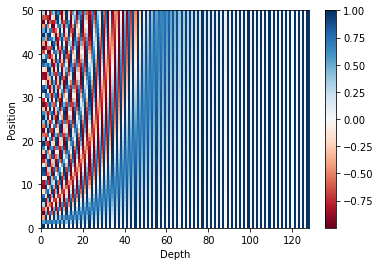

In [ ]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

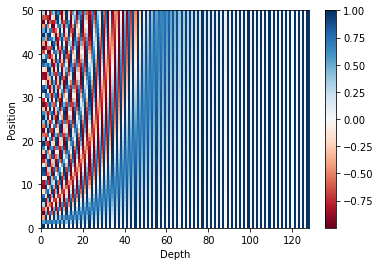

In [ ]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(30000, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0][0:50, :], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
myEnc = encoder(30000, 5, 256, 64, 8, 0.2)

In [ ]:
myEnc.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     1920000     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_1 (TFOpLambda) (None, None, 64)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
positional_encoding_7 (Position (None, None, 64)     0           tf.math.multiply_1[0][0]         
____________________________________________________________________________________________

In [ ]:
input = tf.cast([1, 18, 0, 328, 18, 0, 530, 30, 0, 28, 8, 7], tf.float32)[tf.newaxis, :, tf.newaxis]
padding = create_padding_mask(input)

In [ ]:
input_padd = tf.cast(tf.random.uniform((1,20), 0, 10), dtype = tf.int32)
input2 = tf.cast(tf.random.uniform((20, 64), 0, 1), dtype = tf.float32)[tf.newaxis, :, :]
padding2 = create_padding_mask(input_padd)

In [ ]:
output, attention = scaled_dot_product_attention(input2, input2, input2, padding2)

In [ ]:
attention

<tf.Tensor: shape=(1, 1, 20, 20), dtype=float32, numpy=
array([[[[0.10741478, 0.05397733, 0.05206675, 0.06899861, 0.0627589 ,
          0.04858591, 0.04928834, 0.04418971, 0.04677675, 0.05402303,
          0.        , 0.04384105, 0.05827578, 0.0704679 , 0.05625313,
          0.06692382, 0.        , 0.06140036, 0.        , 0.05475786],
         [0.06196574, 0.10455815, 0.0510079 , 0.07531324, 0.05892237,
          0.05501409, 0.06141714, 0.03449076, 0.03974986, 0.05896524,
          0.        , 0.04718652, 0.04988979, 0.08168951, 0.0545571 ,
          0.05481597, 0.        , 0.05587909, 0.        , 0.0545775 ],
         [0.05487656, 0.04682994, 0.10644521, 0.06661148, 0.0687854 ,
          0.04445849, 0.06448567, 0.04314173, 0.0442063 , 0.05209575,
          0.        , 0.05737803, 0.0531351 , 0.06950404, 0.05807222,
          0.05951608, 0.        , 0.06002566, 0.        , 0.05043237],
         [0.06072005, 0.05773283, 0.05561789, 0.13259591, 0.06128354,
          0.05002961, 0.0494732

In [ ]:
myEnc([input_padd, padding2])

<tf.Tensor: shape=(1, 20, 64), dtype=float32, numpy=
array([[[-0.56689274, -0.9183379 , -0.86261666, ...,  0.583449  ,
          0.9223816 ,  0.42043027],
        [-1.0815585 , -0.85798925, -0.8748499 , ...,  1.0618385 ,
          0.7853019 ,  0.44629073],
        [-0.13030785, -0.3126183 , -1.2167197 , ...,  0.9333594 ,
          0.9531389 , -0.3080056 ],
        ...,
        [ 1.8579004 ,  0.9429028 , -0.01095539, ..., -0.8986366 ,
          1.1284063 ,  0.5920967 ],
        [ 2.5367105 ,  1.5791864 ,  0.68594474, ...,  0.1117232 ,
         -0.03781951, -0.40073907],
        [ 1.7785149 ,  1.8217522 , -0.9503376 , ...,  0.63389844,
         -0.2824579 , -0.12575142]]], dtype=float32)>

In [ ]:
my_encode_layer = encoder_layer(256, 64, 8, 0.2)

In [ ]:
my_encode_layer([input2, padding2])

<tf.Tensor: shape=(1, 20, 64), dtype=float32, numpy=
array([[[ 0.18531276, -0.17470454,  1.2781278 , ..., -1.2017483 ,
          0.358448  ,  0.30908173],
        [-0.41198194, -0.29326507, -0.07679467, ..., -0.67154527,
         -0.15223838, -0.0392458 ],
        [ 0.4287555 ,  1.6630363 , -0.2899906 , ..., -1.9569784 ,
         -0.18131763,  1.2184677 ],
        ...,
        [-2.2448287 ,  1.0673614 , -0.5568974 , ...,  0.6937181 ,
         -0.22324696, -0.5592787 ],
        [ 0.74203646,  0.12143187,  0.17043741, ...,  0.9250108 ,
         -0.15034546, -0.38669547],
        [ 1.23434   , -0.42977098,  0.31257147, ...,  1.5177709 ,
         -0.12250929, -0.4972128 ]]], dtype=float32)>

In [ ]:
my_mha = MultiHeadAttention(d_model = 64, num_head = 8)
output = my_mha({'query' : input2, 'key' : input2, 'value' : input2, 'mask': padding2})

In [ ]:
output

<tf.Tensor: shape=(1, 20, 64), dtype=float32, numpy=
array([[[ 0.02596099, -0.18954545,  0.10265657, ...,  0.06904027,
         -0.12526794,  0.15080036],
        [ 0.02616859, -0.20332208,  0.10094622, ...,  0.06374037,
         -0.12148902,  0.14625753],
        [ 0.49893534, -0.22571662,  0.57093865, ...,  0.48565742,
         -0.22054419, -0.4454599 ],
        ...,
        [ 0.38715363,  0.01514635,  1.0614694 , ...,  0.7392822 ,
          0.32191187, -0.5422954 ],
        [ 0.6380751 , -0.30788895,  0.72129184, ...,  0.28224212,
          0.15393972, -0.61489105],
        [ 0.6334094 , -0.31176805,  0.7632511 , ...,  0.2732637 ,
          0.17699414, -0.6166239 ]]], dtype=float32)>